So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before
Vanilla Gumbel

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025238
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364944
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.814362
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.379112
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789692
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.276009
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.740120
====> Epoch: 1 Average loss: 40.2651
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.672573
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.857533
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.325977
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.101463
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.596703
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.989117
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.360310
====> Epoch: 2 Average loss: 36.4149
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.523701
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.206936
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.856945
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.793369
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.988956
Train E

tensor(32347.5605, device='cuda:0')
tensor(61637.8672, device='cuda:0')


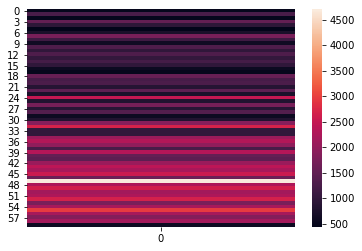

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(21062.8887, device='cuda:0')
tensor(50317.8398, device='cuda:0')


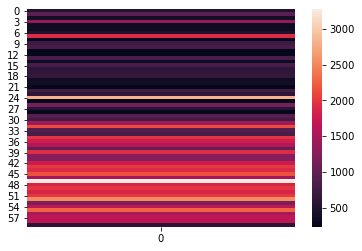

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2645.6238, device='cuda:0')
tensor(3498.3762, device='cuda:0')


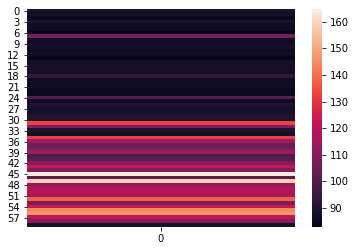

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1339.3340, device='cuda:0')
tensor(1732.6660, device='cuda:0')


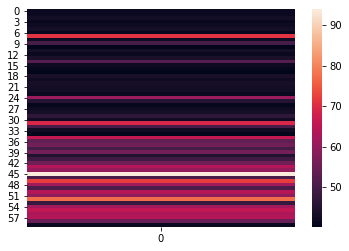

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(-393.3320, device='cuda:0')

**VAE_Gumbel_NInsta test here**

In [19]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [20]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.400688
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.591465
Train Epoch: 1 [2560/8000 (32%)]	Loss: 41.091648
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.729820
Train Epoch: 1 [5120/8000 (64%)]	Loss: 40.118912
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.473454
Train Epoch: 1 [7680/8000 (96%)]	Loss: 39.077679
====> Epoch: 1 Average loss: 40.5664
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.925514
Train Epoch: 2 [1280/8000 (16%)]	Loss: 38.373909
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.595001
Train Epoch: 2 [3840/8000 (48%)]	Loss: 37.242809
Train Epoch: 2 [5120/8000 (64%)]	Loss: 36.180275
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.880650
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.788918
====> Epoch: 2 Average loss: 36.8954
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.725903
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.448414
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.223343
Train Epoch: 3 [3840/8000 (48%)]	Loss: 34.048428
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.678936
Train E

tensor(22931.5059, device='cuda:0')
tensor(53759.5430, device='cuda:0')


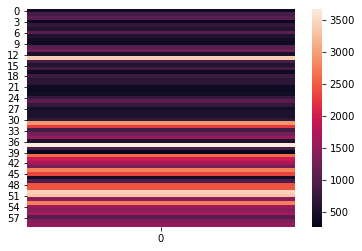

In [21]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(12770.2305, device='cuda:0')
tensor(45516.1445, device='cuda:0')


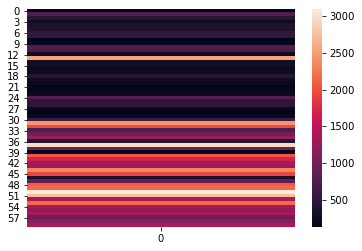

In [22]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(39.4364, device='cuda:0')
tensor(56.5636, device='cuda:0')


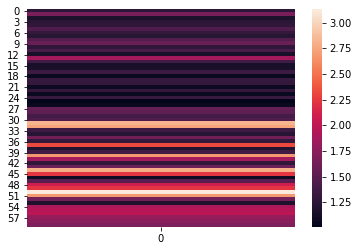

In [23]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(18.6865, device='cuda:0')
tensor(29.3135, device='cuda:0')


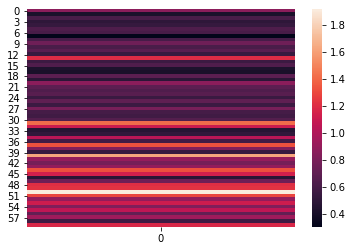

In [24]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [25]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(-10.6270, device='cuda:0')

The new model


In [26]:
logits_changed_loss_lambda = 0.001
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [27]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      logits_changed_loss_lambda = 0.001,
                                                      Dim = 2*D, DEBUG = True)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.918343
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.333893
Loss tensor(2625.6252, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5056.7056, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.868099
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.314308
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.795437
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.168621
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.642033
====> Epoch: 1 Average loss: 40.1919
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.427498
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.684792
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.135033
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.465237
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.717560
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.382233
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.572712
====> Epoch: 2 Average loss: 36.3695
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.347126
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.046322
Loss tensor(2172.

tensor(1161.0712, device='cuda:0')
tensor(1565.4916, device='cuda:0')


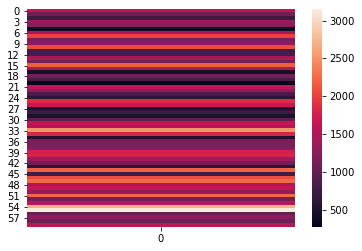

In [28]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(741.9973, device='cuda:0')
tensor(1195.7576, device='cuda:0')


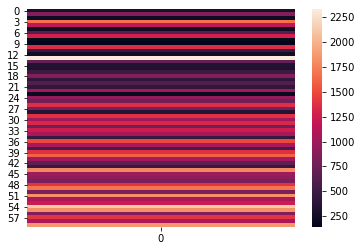

In [29]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(47.5587, device='cuda:0')
tensor(48.4413, device='cuda:0')


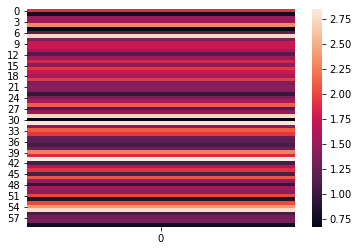

In [30]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(22.5856, device='cuda:0')
tensor(25.4144, device='cuda:0')


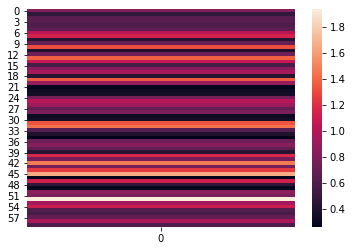

In [31]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [32]:
subset_indices_post_burnin[:(D)]

tensor([0.8297, 0.4835, 0.6416, 0.6521, 0.6077, 0.6574, 1.0219, 1.1429, 0.4197,
        0.7035, 1.3126, 0.4040, 0.7498, 1.3846, 1.0815, 0.5807, 0.8365, 0.9529,
        0.4350, 1.3570, 0.8961, 0.2727, 0.3266, 0.3558, 0.7615, 1.0251, 0.9148,
        0.6822, 0.7803, 0.3162], device='cuda:0')

In [33]:
subset_indices_post_burnin[(D):]

tensor([0.3490, 1.3344, 1.4346, 0.6326, 0.4035, 0.2753, 0.7223, 0.8283, 0.6898,
        0.4426, 1.1653, 0.7760, 1.4671, 0.7538, 1.2450, 1.6546, 0.2626, 1.1255,
        0.4741, 0.2953, 0.8533, 0.7788, 1.9352, 0.9415, 1.1077, 0.6160, 0.5810,
        0.6933, 0.9718, 0.6043], device='cuda:0')

In [34]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(-2.8288, device='cuda:0')

In [35]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [36]:
sum(top_ind < 30)

tensor(11, device='cuda:0')

In [37]:
sum(top_ind >= 30)

tensor(13, device='cuda:0')